In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import tiffslide as openslide
from PIL import Image
import cv2

def normalize_mask(image, target_dtype=np.uint8):
    normalized_image = cv2.normalize(image, None, 0, np.iinfo(target_dtype).max, cv2.NORM_MINMAX)
    return normalized_image.astype(target_dtype)

# Open the slide and normalize it
read_PODO = openslide.open_slide("/blue/pinaki.sarder/j.maragall/P12_594_PAS_07242017.tif")
PODO_mask = normalize_mask(np.array(read_PODO.get_thumbnail(read_PODO.dimensions)), np.uint8)


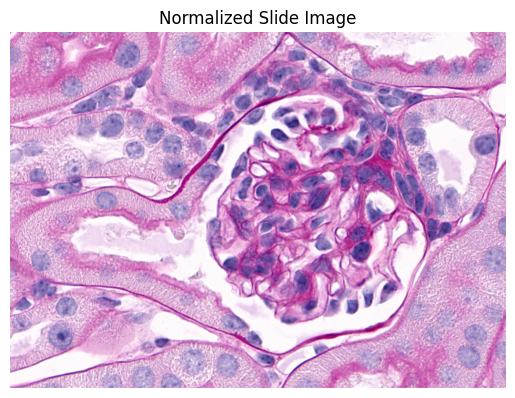

In [2]:
import matplotlib.pyplot as plt

# Assuming PODO_mask contains the normalized image data
plt.imshow(PODO_mask)
plt.title("Normalized Slide Image")
plt.axis('off')  # Hide the axis to focus on the image
plt.show()


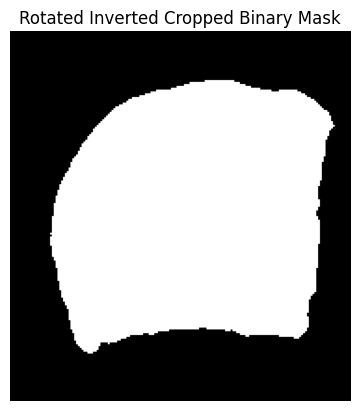

In [28]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Load the image
image_path = "/blue/pinaki.sarder/j.maragall/P2.png"
image = Image.open(image_path).convert('L')  # Convert to grayscale

# Convert image to numpy array
image_np = np.array(image)

# Define the intensity threshold
intensity_threshold = 150  # Adjust this as needed

# Create a binary mask
_, binary_mask = cv2.threshold(image_np, intensity_threshold, 255, cv2.THRESH_BINARY)

# Find connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_mask, connectivity=8)

# Define pixel count threshold
pixel_count_threshold = 172300  # Adjust this as needed

# Create a new mask for keeping only large components
cleaned_mask = np.zeros_like(binary_mask, dtype=np.uint8)
for i in range(1, num_labels):  # Start from 1 to ignore the background
    if stats[i, cv2.CC_STAT_AREA] >= pixel_count_threshold:
        cleaned_mask[labels == i] = 255

# Invert the binary mask
inverted_mask = 255 - cleaned_mask

# Calculate new dimensions for cropping (34% smaller in area for height)
new_height = int(np.sqrt(2) * inverted_mask.shape[0])
new_width = int(1.1 * new_height)  # Making width 10% larger than the new height

# Determine the center of the image
center_x, center_y = inverted_mask.shape[1] // 2, inverted_mask.shape[0] // 2

# Define the crop area using non-integer divisor for division
start_x = max(int(center_x - new_width // 1), 0)
start_y = max(center_y - new_height // 2, 0)
end_x = start_x + new_width
end_y = start_y + new_height

# Crop the image
cropped_image = inverted_mask[start_y:end_y, start_x:end_x]

# Invert the cropped image over the x-axis
inverted_cropped_image = np.flip(cropped_image, axis=0)

# Rotate the inverted cropped image by 90 degrees
rotated_inverted_cropped_image = np.rot90(inverted_cropped_image)

# Visualize the rotated inverted cropped binary mask
plt.imshow(rotated_inverted_cropped_image, cmap='gray')
plt.title("Rotated Inverted Cropped Binary Mask")
plt.axis('off')
plt.show()

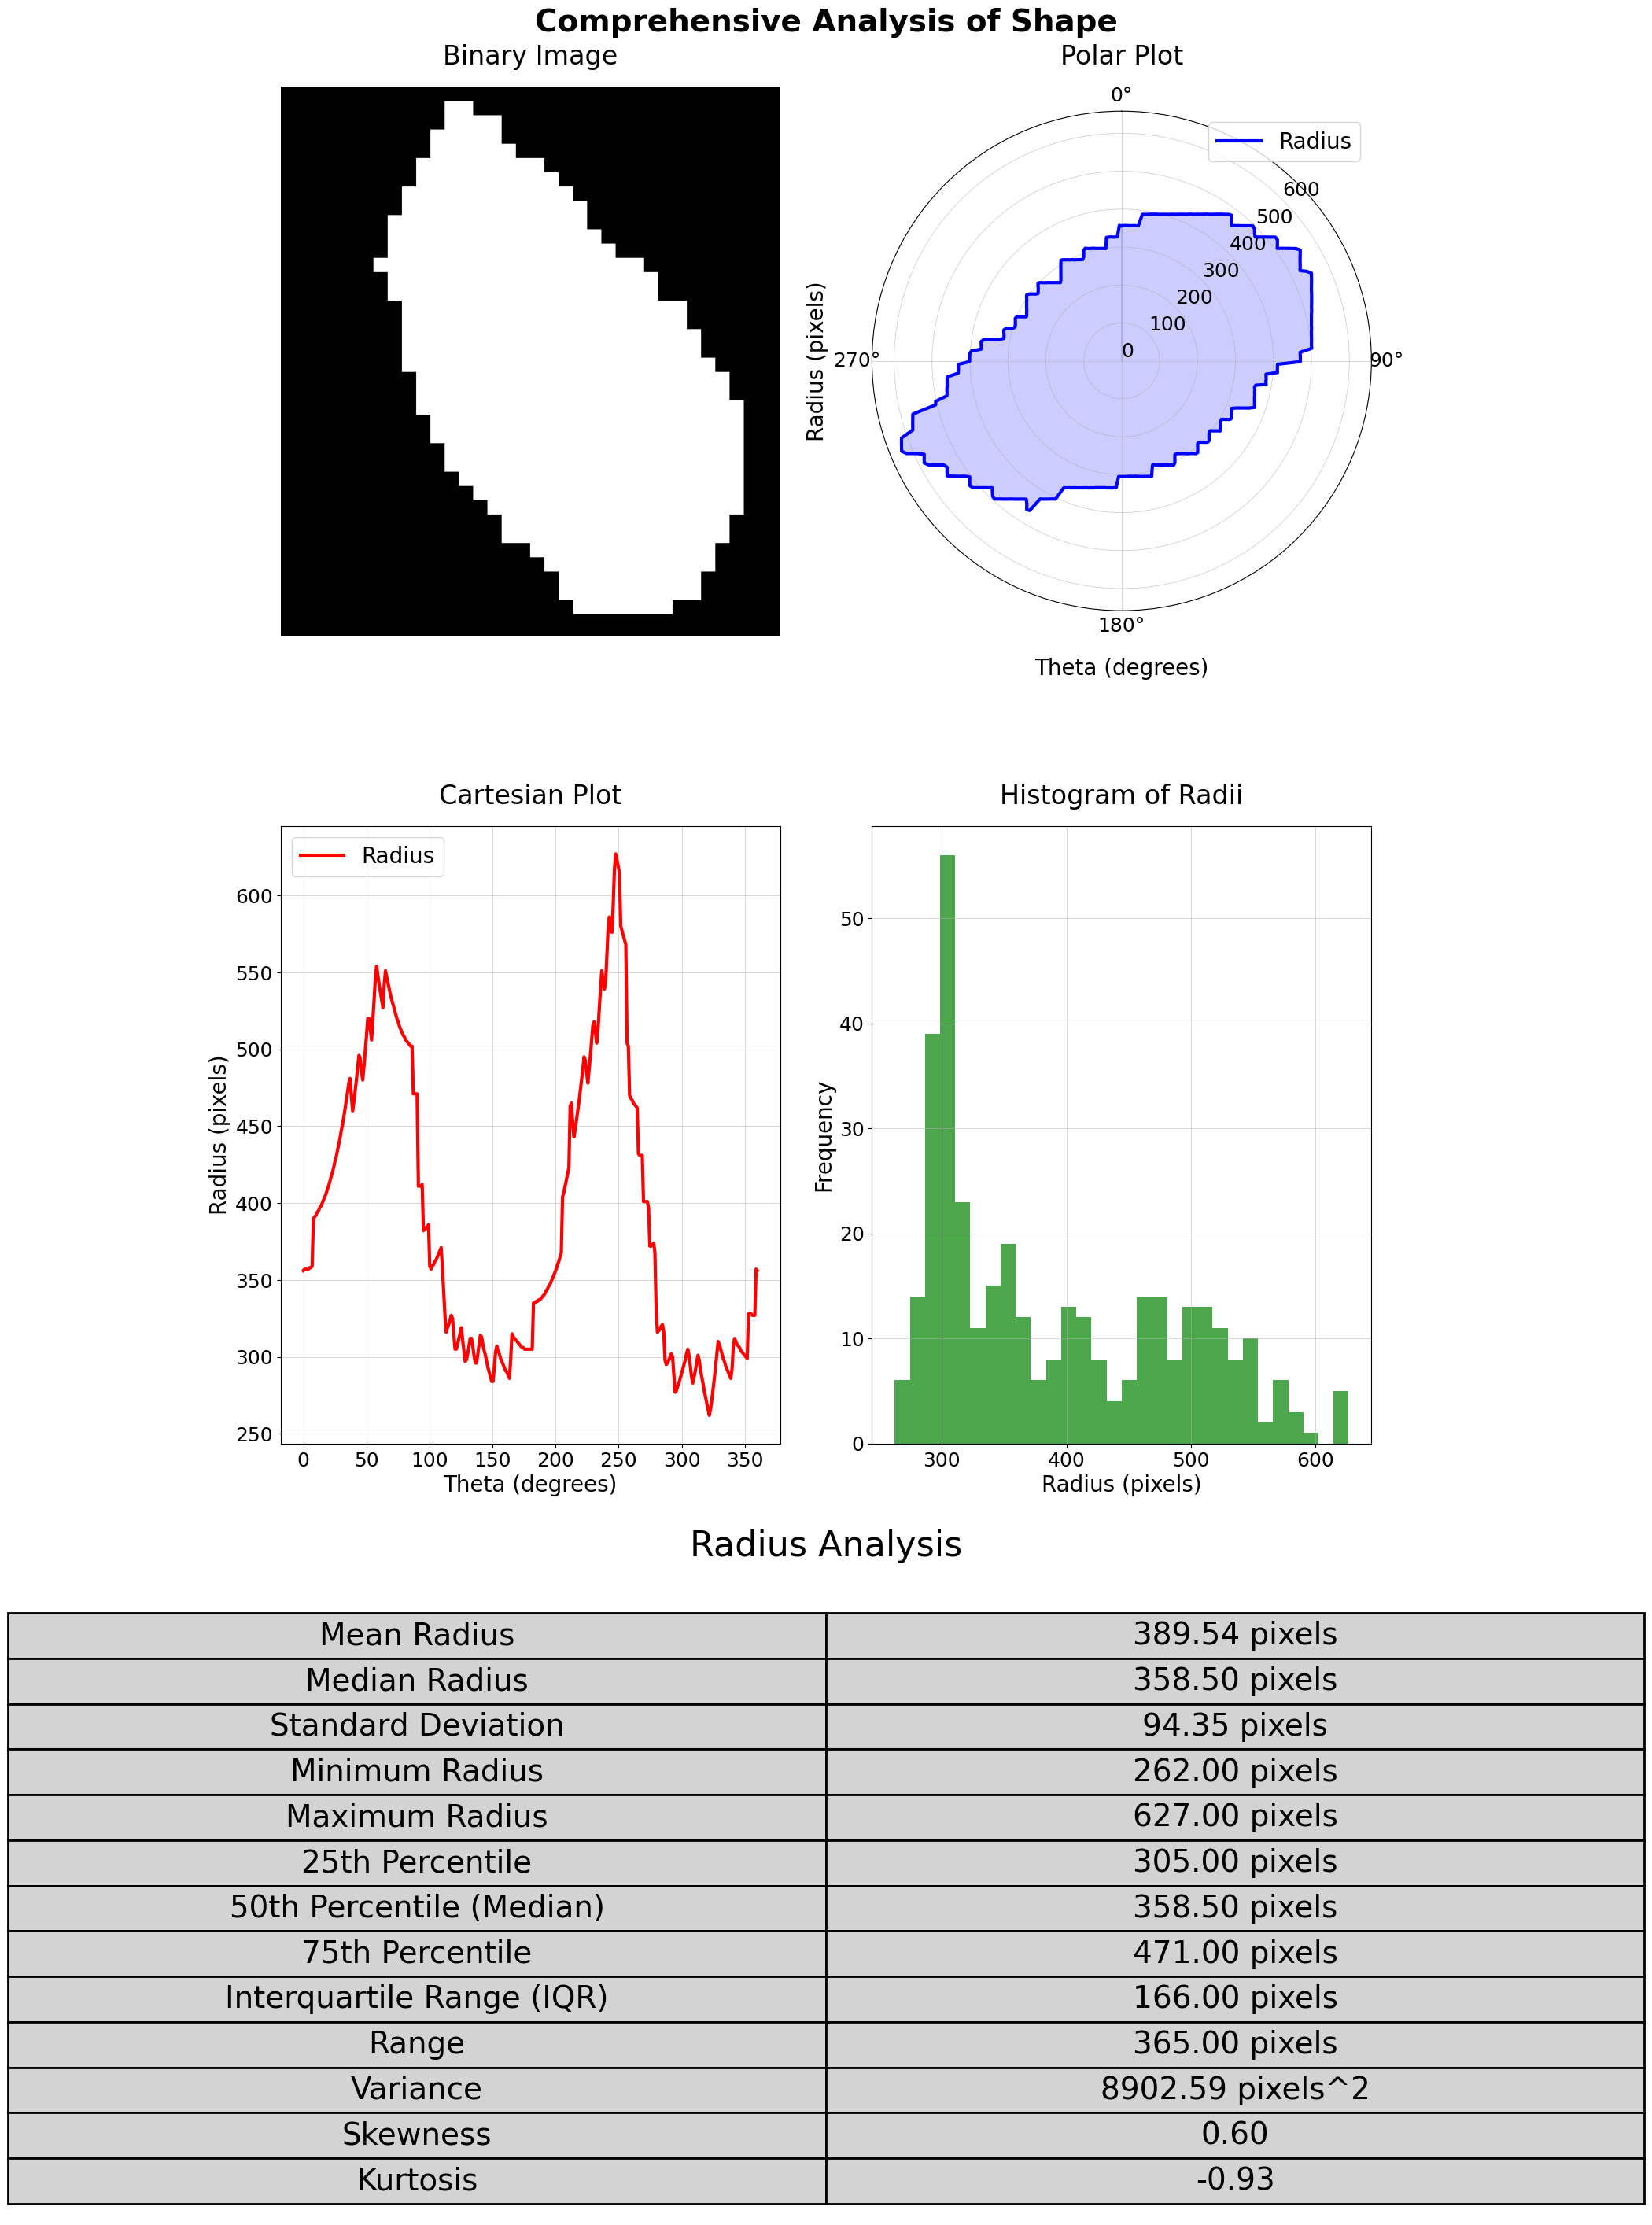

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming inverted_cropped_image and cropped_image are the binary masks obtained from previous steps

# Compute the centroid of the binary shape
y_coords, x_coords = np.where(rotated_inverted_cropped_image == 255)
centroid_x = int(np.mean(x_coords))
centroid_y = int(np.mean(y_coords))

# Calculate radius r for each theta from 0 to 360 degrees
theta_range = np.linspace(0, 360, 360)  # 1 degree increments
radii = []
for theta in theta_range:
    theta_rad = np.deg2rad(theta)
    step_x = np.cos(theta_rad)
    step_y = np.sin(theta_rad)
    distance = 0
    x, y = centroid_x, centroid_y
    while 0 <= int(y) < rotated_inverted_cropped_image.shape[0] and 0 <= int(x) < rotated_inverted_cropped_image.shape[1] and rotated_inverted_cropped_image[int(y), int(x)] == 255:
        x += step_x
        y += step_y
        distance += 1
    radii.append(distance)

# Convert to numpy array for easy handling
radii = np.array(radii)

# Create a figure with subplots
fig = plt.figure(figsize=(24, 30))
fig.suptitle('Comprehensive Analysis of Shape', fontsize=28, fontweight='bold', y=0.95)

# Cropped image plot
ax1 = fig.add_subplot(321)
ax1.imshow(rotated_inverted_cropped_image, cmap='gray')
ax1.set_title('Binary Image', fontsize=24, pad=20)
ax1.axis('off')

# Polar plot
ax2 = fig.add_subplot(322, projection='polar')
ax2.plot(np.deg2rad(theta_range), radii, linewidth=3, color='blue', label='Radius')
ax2.set_title('Polar Plot', fontsize=24, pad=20)
ax2.set_xlabel('Theta (degrees)', fontsize=20, labelpad=20)
ax2.set_ylabel('Radius (pixels)', fontsize=20, labelpad=40)
ax2.set_theta_zero_location("N")
ax2.set_theta_direction(-1)
ax2.set_rlabel_position(45)
ax2.set_xticks(np.deg2rad([0, 90, 180, 270]))
ax2.set_xticklabels(['0°', '90°', '180°', '270°'], fontsize=18)
ax2.set_yticks(np.arange(0, max(radii), 100))  # Set radial ticks every 100 units
ax2.set_yticklabels(np.arange(0, max(radii), 100), fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.legend(fontsize=20, loc='upper right')
ax2.grid(True, linewidth=0.5, alpha=0.7)
ax2.fill_between(np.deg2rad(theta_range), radii, alpha=0.2, color='blue')

# Cartesian plot
ax3 = fig.add_subplot(323)
ax3.plot(theta_range, radii, linewidth=3, color='red', label='Radius')
ax3.set_title('Cartesian Plot', fontsize=24, pad=20)
ax3.set_xlabel('Theta (degrees)', fontsize=20)
ax3.set_ylabel('Radius (pixels)', fontsize=20)
ax3.grid(True, linewidth=0.5, alpha=0.7)
ax3.legend(fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=18)

# Histogram of radii
ax4 = fig.add_subplot(324)
ax4.hist(radii, bins=30, color='green', alpha=0.7)
ax4.set_title('Histogram of Radii', fontsize=24, pad=20)
ax4.set_xlabel('Radius (pixels)', fontsize=20)
ax4.set_ylabel('Frequency', fontsize=20)
ax4.grid(True, linewidth=0.5, alpha=0.7)
ax4.tick_params(axis='both', which='major', labelsize=18)

# Radius analysis table
ax5 = fig.add_subplot(313)
ax5.axis('off')

# Compute radius statistics
mean_radius = np.mean(radii)
median_radius = np.median(radii)
std_radius = np.std(radii)
min_radius = np.min(radii)
max_radius = np.max(radii)
percentiles = np.percentile(radii, [25, 50, 75])
iqr = percentiles[2] - percentiles[0]
radius_range = max_radius - min_radius
variance = np.var(radii)
skewness = pd.Series(radii).skew()
kurtosis = pd.Series(radii).kurtosis()

# Create a table with radius statistics
table_data = [
    ['Mean Radius', f'{mean_radius:.2f} pixels'],
    ['Median Radius', f'{median_radius:.2f} pixels'],
    ['Standard Deviation', f'{std_radius:.2f} pixels'],
    ['Minimum Radius', f'{min_radius:.2f} pixels'],
    ['Maximum Radius', f'{max_radius:.2f} pixels'],
    ['25th Percentile', f'{percentiles[0]:.2f} pixels'],
    ['50th Percentile (Median)', f'{percentiles[1]:.2f} pixels'],
    ['75th Percentile', f'{percentiles[2]:.2f} pixels'],
    ['Interquartile Range (IQR)', f'{iqr:.2f} pixels'],
    ['Range', f'{radius_range:.2f} pixels'],
    ['Variance', f'{variance:.2f} pixels^2'],
    ['Skewness', f'{skewness:.2f}'],
    ['Kurtosis', f'{kurtosis:.2f}']
]

# Create the table with larger font size and cell dimensions
table = ax5.table(cellText=table_data, cellLoc='center', loc='center', fontsize=28, cellColours=[['lightgray']*2]*len(table_data))

# Adjust the table size and position
table.scale(1.5, 3)  # Increase the scale factors for width and height
table.set_fontsize(28)  # Increase the font size of the table cells

# Adjust the cell padding
for key, cell in table.get_celld().items():
    cell.set_linewidth(2)  # Increase the cell border line width
    cell.set_edgecolor('black')  # Set the cell border color
    cell.PAD = 0.1  # Increase the cell padding

ax5.set_title('Radius Analysis', fontsize=32, pad=40)

plt.tight_layout(pad=3.0)
plt.show()

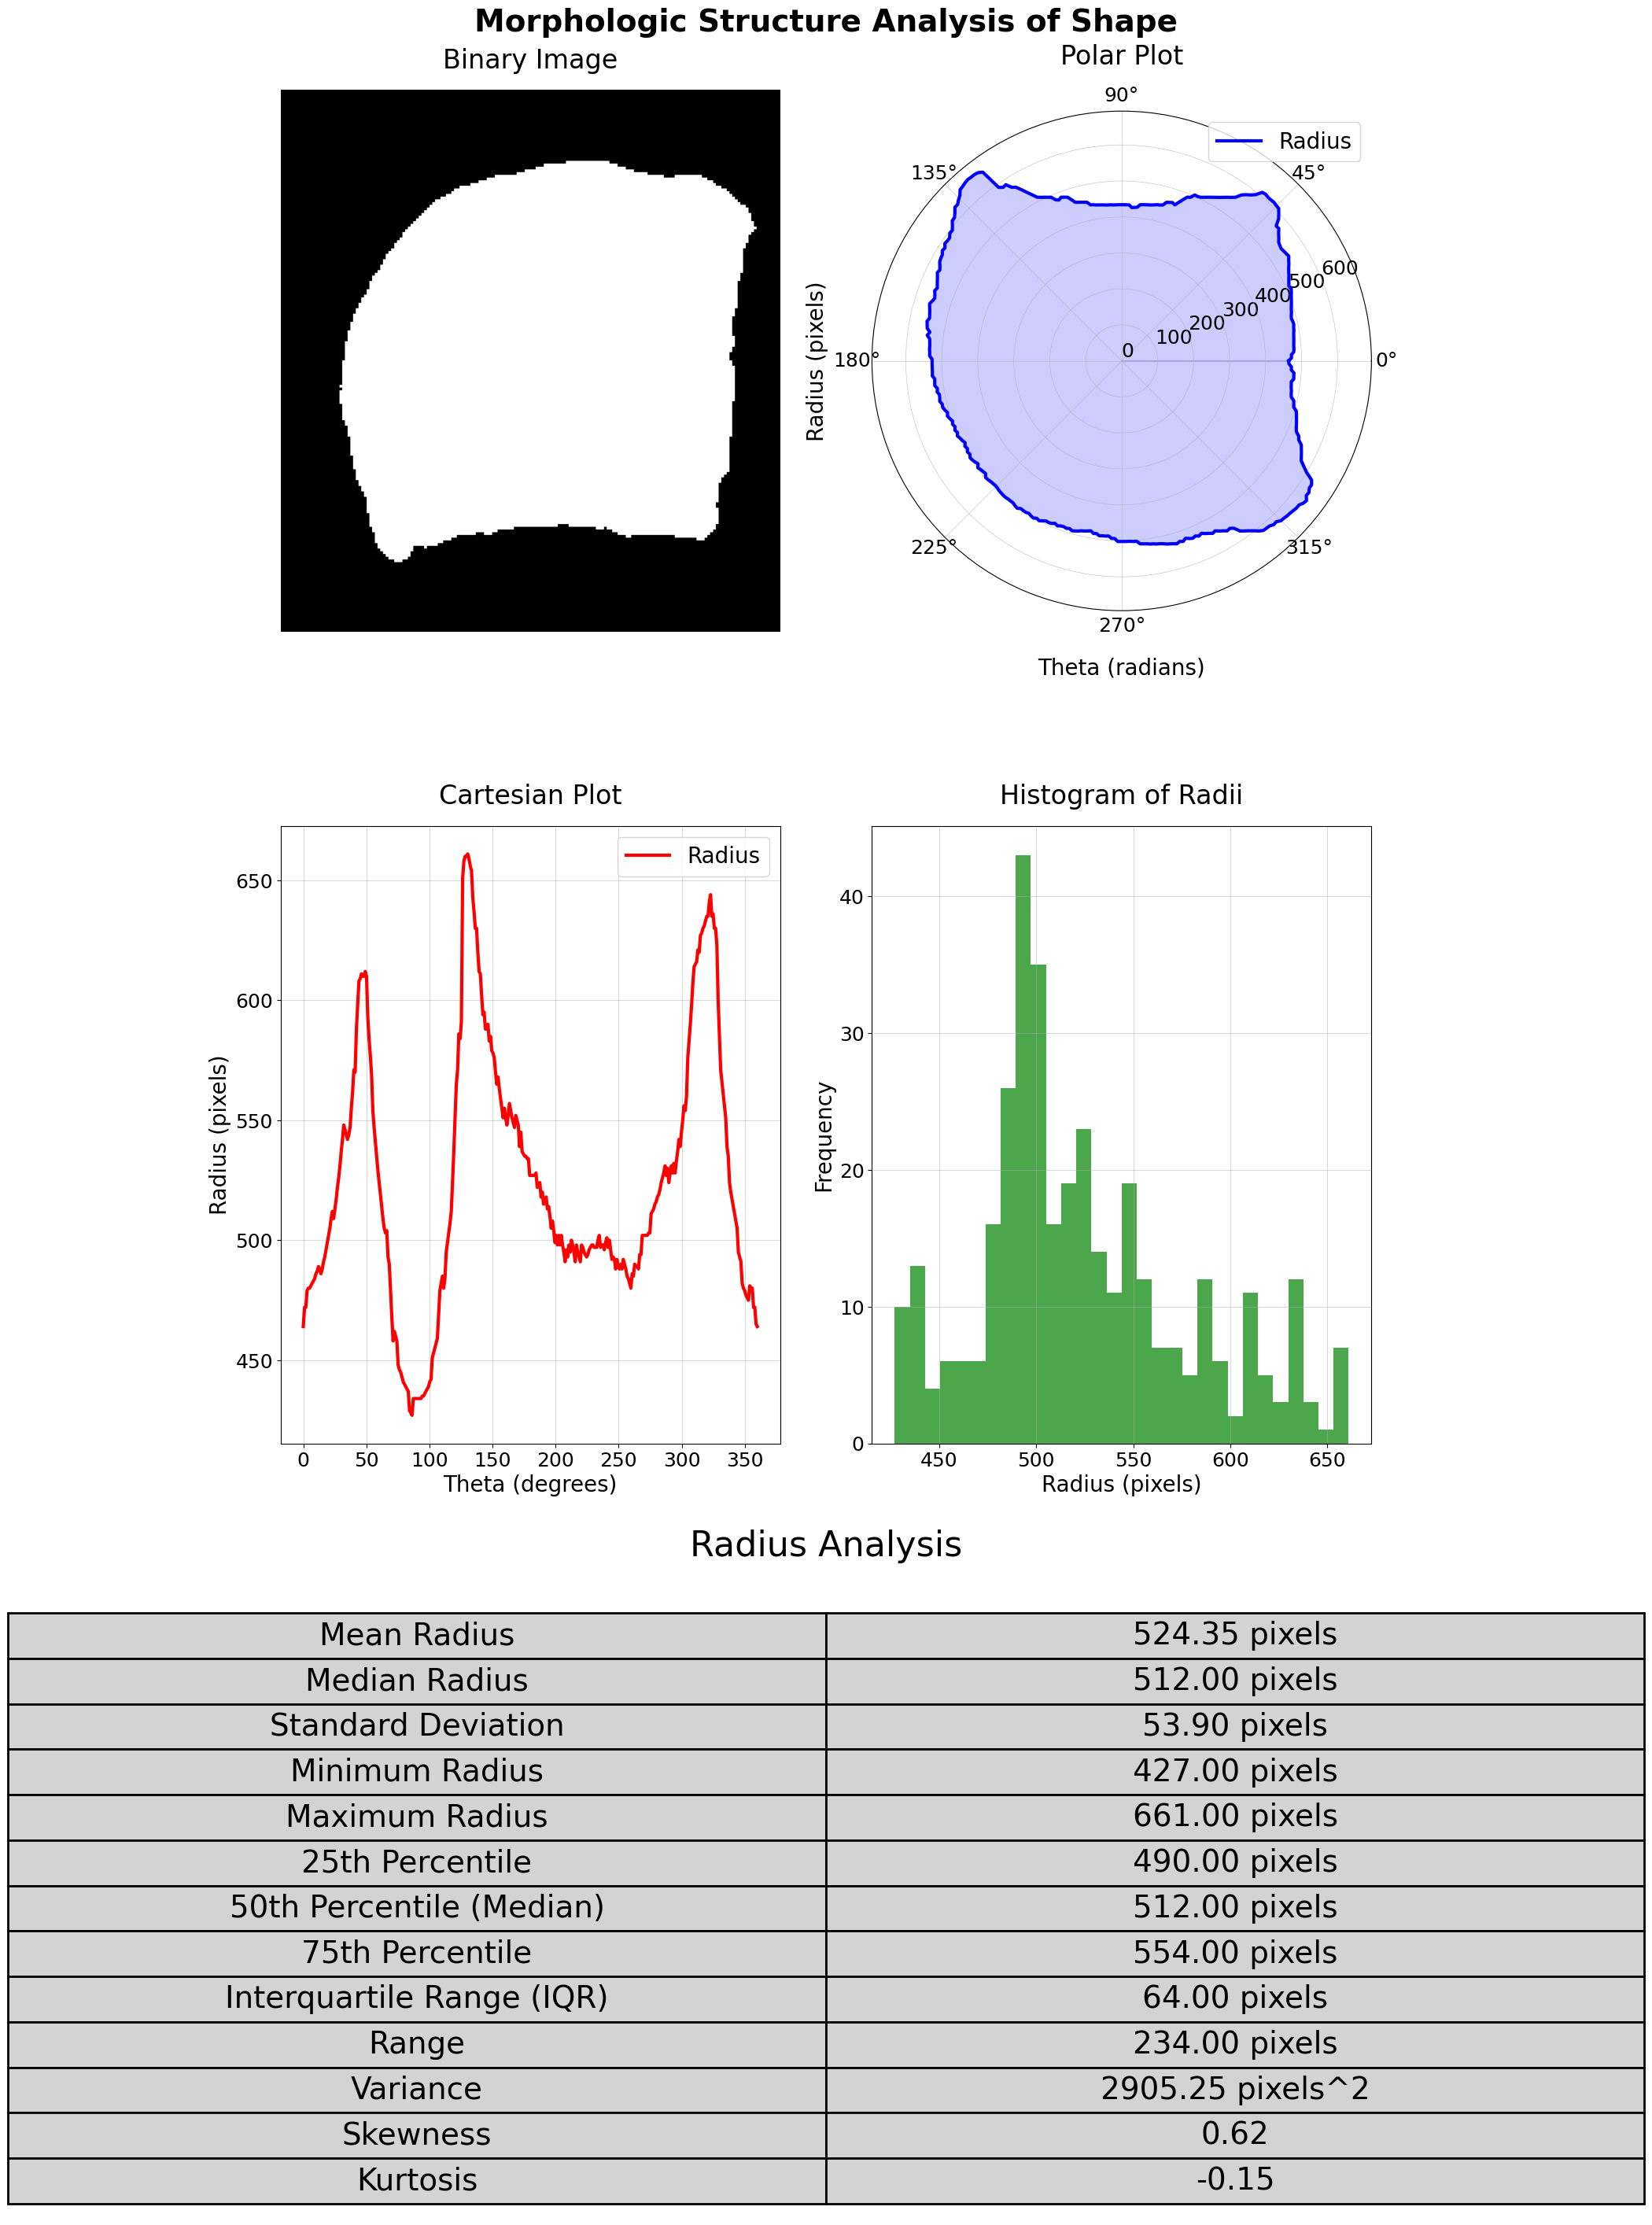

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming inverted_cropped_image and cropped_image are the binary masks obtained from previous steps

# Compute the centroid of the binary shape
y_coords, x_coords = np.where(rotated_inverted_cropped_image == 255)
centroid_x = int(np.mean(x_coords))
centroid_y = int(np.mean(y_coords))

# Calculate radius r for each theta from 0 to 360 degrees
theta_range = np.linspace(0, 2*np.pi, 360)  # Theta in radians
radii = []
for theta in theta_range:
    step_x = np.cos(theta)
    step_y = np.sin(theta)
    distance = 0
    x, y = centroid_x, centroid_y
    while 0 <= int(y) < rotated_inverted_cropped_image.shape[0] and 0 <= int(x) < rotated_inverted_cropped_image.shape[1] and rotated_inverted_cropped_image[int(y), int(x)] == 255:
        x += step_x
        y += step_y
        distance += 1
    radii.append(distance)

# Convert to numpy array for easy handling
radii = np.array(radii)

# Create a figure with subplots
fig = plt.figure(figsize=(24, 30))
fig.suptitle('Morphologic Structure Analysis of Shape', fontsize=28, fontweight='bold', y=0.95)

# Cropped image plot
ax1 = fig.add_subplot(321)
ax1.imshow(rotated_inverted_cropped_image, cmap='gray')
ax1.set_title('Binary Image', fontsize=24, pad=20)
ax1.axis('off')

# Polar plot
ax2 = fig.add_subplot(322, projection='polar')
ax2.plot(theta_range, radii, linewidth=3, color='blue', label='Radius')
ax2.set_title('Polar Plot', fontsize=24, pad=20)
ax2.set_xlabel('Theta (radians)', fontsize=20, labelpad=20)
ax2.set_ylabel('Radius (pixels)', fontsize=20, labelpad=40)
ax2.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
ax2.set_xticklabels([f'{np.degrees(theta):.0f}°' for theta in np.linspace(0, 2*np.pi, 8, endpoint=False)], fontsize=18)
ax2.set_yticks(np.arange(0, max(radii), 100))  # Set radial ticks every 100 units
ax2.set_yticklabels(np.arange(0, max(radii), 100), fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax2.legend(fontsize=20, loc='upper right')
ax2.grid(True, linewidth=0.5, alpha=0.7)
ax2.fill_between(theta_range, radii, alpha=0.2, color='blue')

# Cartesian plot
ax3 = fig.add_subplot(323)
ax3.plot(np.degrees(theta_range), radii, linewidth=3, color='red', label='Radius')
ax3.set_title('Cartesian Plot', fontsize=24, pad=20)
ax3.set_xlabel('Theta (degrees)', fontsize=20)
ax3.set_ylabel('Radius (pixels)', fontsize=20)
ax3.grid(True, linewidth=0.5, alpha=0.7)
ax3.legend(fontsize=20)
ax3.tick_params(axis='both', which='major', labelsize=18)

# Histogram of radii
ax4 = fig.add_subplot(324)
ax4.hist(radii, bins=30, color='green', alpha=0.7)
ax4.set_title('Histogram of Radii', fontsize=24, pad=20)
ax4.set_xlabel('Radius (pixels)', fontsize=20)
ax4.set_ylabel('Frequency', fontsize=20)
ax4.grid(True, linewidth=0.5, alpha=0.7)
ax4.tick_params(axis='both', which='major', labelsize=18)

# Radius analysis table
ax5 = fig.add_subplot(313)
ax5.axis('off')

# Compute radius statistics
mean_radius = np.mean(radii)
median_radius = np.median(radii)
std_radius = np.std(radii)
min_radius = np.min(radii)
max_radius = np.max(radii)
percentiles = np.percentile(radii, [25, 50, 75])
iqr = percentiles[2] - percentiles[0]
radius_range = max_radius - min_radius
variance = np.var(radii)
skewness = pd.Series(radii).skew()
kurtosis = pd.Series(radii).kurtosis()

# Create a table with radius statistics
table_data = [
    ['Mean Radius', f'{mean_radius:.2f} pixels'],
    ['Median Radius', f'{median_radius:.2f} pixels'],
    ['Standard Deviation', f'{std_radius:.2f} pixels'],
    ['Minimum Radius', f'{min_radius:.2f} pixels'],
    ['Maximum Radius', f'{max_radius:.2f} pixels'],
    ['25th Percentile', f'{percentiles[0]:.2f} pixels'],
    ['50th Percentile (Median)', f'{percentiles[1]:.2f} pixels'],
    ['75th Percentile', f'{percentiles[2]:.2f} pixels'],
    ['Interquartile Range (IQR)', f'{iqr:.2f} pixels'],
    ['Range', f'{radius_range:.2f} pixels'],
    ['Variance', f'{variance:.2f} pixels^2'],
    ['Skewness', f'{skewness:.2f}'],
    ['Kurtosis', f'{kurtosis:.2f}']
]

# Create the table with larger font size and cell dimensions
table = ax5.table(cellText=table_data, cellLoc='center', loc='center', fontsize=28, cellColours=[['lightgray']*2]*len(table_data))

# Adjust the table size and position
table.scale(1.5, 3)  # Increase the scale factors for width and height
table.set_fontsize(28)  # Increase the font size of the table cells

# Adjust the cell padding
for key, cell in table.get_celld().items():
    cell.set_linewidth(2)  # Increase the cell border line width
    cell.set_edgecolor('black')  # Set the cell border color
    cell.PAD = 0.1  # Increase the cell padding

ax5.set_title('Radius Analysis', fontsize=32, pad=40)

fig.savefig('2_comprehensive_shape_analysis.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.tight_layout(pad=3.0)
plt.show()



In [172]:
pwd

'/home/j.maragall/Pipeline_CellMapping'

/scratch/local/30359534/ipykernel_3307121/1003243618.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f'{np.degrees(theta):.0f}°' for theta in np.linspace(0, 2*np.pi, 8, endpoint=False)], fontsize=25)
/scratch/local/30359534/ipykernel_3307121/1003243618.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels(np.arange(0, max(radii), 100), fontsize=25)


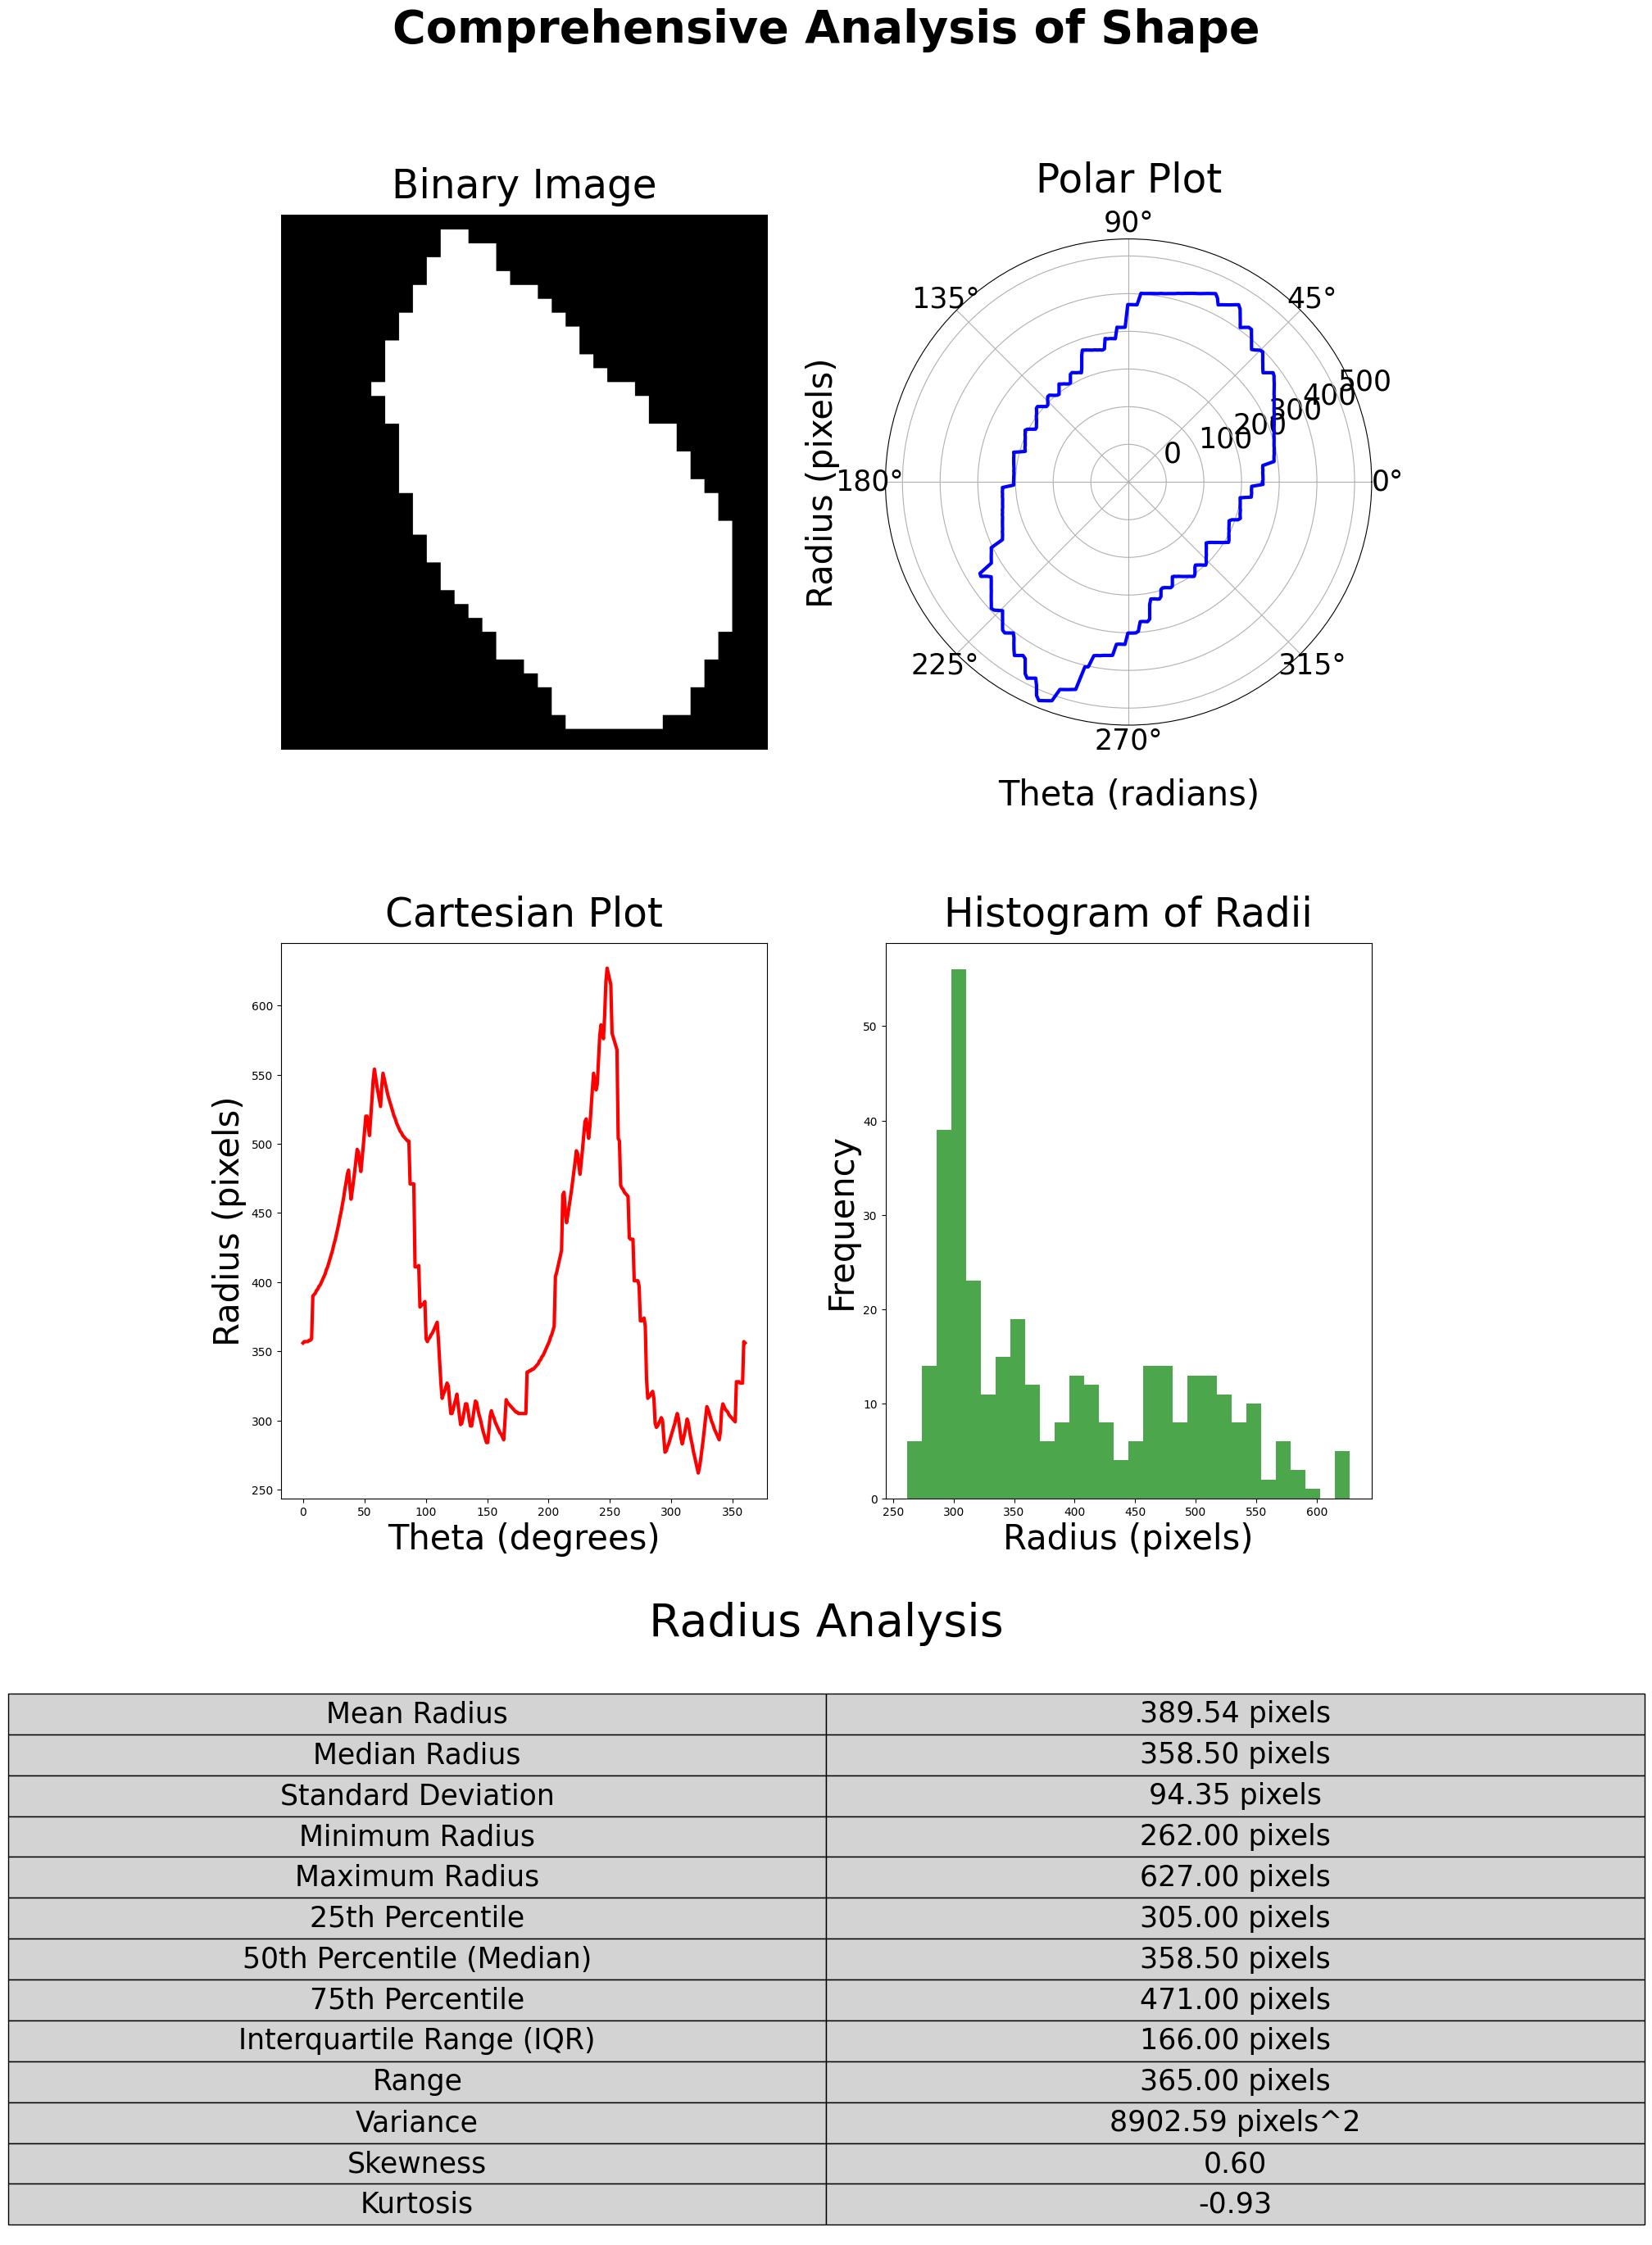

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming inverted_cropped_image and cropped_image are the binary masks obtained from previous steps

# Compute the centroid of the binary shape
y_coords, x_coords = np.where(rotated_inverted_cropped_image == 255)
centroid_x = int(np.mean(x_coords))
centroid_y = int(np.mean(y_coords))

# Calculate radius r for each theta from 0 to 360 degrees
theta_range = np.linspace(0, 2*np.pi, 360)  # Theta in radians
radii = []
for theta in theta_range:
    step_x = np.cos(theta)
    step_y = np.sin(theta)
    distance = 0
    x, y = centroid_x, centroid_y
    while 0 <= int(y) < rotated_inverted_cropped_image.shape[0] and 0 <= int(x) < rotated_inverted_cropped_image.shape[1] and rotated_inverted_cropped_image[int(y), int(x)] == 255:
        x += step_x
        y += step_y
        distance += 1
    radii.append(distance)

# Convert to numpy array for easy handling
radii = np.array(radii)

# Create a figure with subplots
fig = plt.figure(figsize=(24, 30))
fig.suptitle('Comprehensive Analysis of Shape', fontsize=40, fontweight='bold', y=0.93)

# Cropped image plot
ax1 = fig.add_subplot(321)
ax1.imshow(rotated_inverted_cropped_image, cmap='gray')
ax1.set_title('Binary Image', fontsize=35, pad=15)
ax1.axis('off')

# Polar plot
ax2 = fig.add_subplot(322, projection='polar')
ax2.plot(theta_range, radii, linewidth=3, color='blue', label='Radius')
ax2.set_title('Polar Plot', fontsize=35, pad=15)
ax2.set_xlabel('Theta (radians)', fontsize=30, labelpad=20)
ax2.set_ylabel('Radius (pixels)', fontsize=30, labelpad=40)
ax2.set_xticklabels([f'{np.degrees(theta):.0f}°' for theta in np.linspace(0, 2*np.pi, 8, endpoint=False)], fontsize=25)
ax2.set_yticklabels(np.arange(0, max(radii), 100), fontsize=25)


# Cartesian plot
ax3 = fig.add_subplot(323)
ax3.plot(np.degrees(theta_range), radii, linewidth=3, color='red', label='Radius')
ax3.set_title('Cartesian Plot', fontsize=35, pad=15)
ax3.set_xlabel('Theta (degrees)', fontsize=30)
ax3.set_ylabel('Radius (pixels)', fontsize=30)

# Histogram of radii
ax4 = fig.add_subplot(324)
ax4.hist(radii, bins=30, color='green', alpha=0.7)
ax4.set_title('Histogram of Radii', fontsize=35, pad=15)
ax4.set_xlabel('Radius (pixels)', fontsize=30)
ax4.set_ylabel('Frequency', fontsize=30)

# Radius analysis table
ax5 = fig.add_subplot(313)
ax5.axis('off')
table = ax5.table(cellText=table_data, cellLoc='center', loc='center', fontsize=25, cellColours=[['lightgray']*2]*len(table_data))
table.scale(1.5, 3)
table.set_fontsize(25)
ax5.set_title('Radius Analysis', fontsize=40, pad=40)

# Adjust layout
plt.tight_layout(pad=5.0)
fig.subplots_adjust(top=0.85)  # Adjust the top to make space for the main title

# Save and show the figure
fig.savefig('comprehensive_shape_analysis.png', dpi=300, bbox_inches='tight', pad_inches=0.5)
plt.show()
